Myopic deconvolution algorithm from

Thibon, Louis, Ferréol Soulez, and Éric Thiébaut. _Fast automatic
myopic deconvolution of angiogram sequence_. In International
Symposium on Biomedical Imaging. Beijing, China, 2014. https://hal.archives-ouvertes.fr/hal-00914846.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.io import imread
from skimage import img_as_float
from auto_metro.myopic_deconv import MODE_NAMES, zernike_tf, deconvolution,power_law
from auto_metro.utils import _fft, _ifft
from scipy.optimize import minimize

mpl.rcParams['figure.figsize'] = (12, 9)



In [2]:
image = img_as_float(imread("../../samples/pencil.tif"))
nx, ny = image.shape

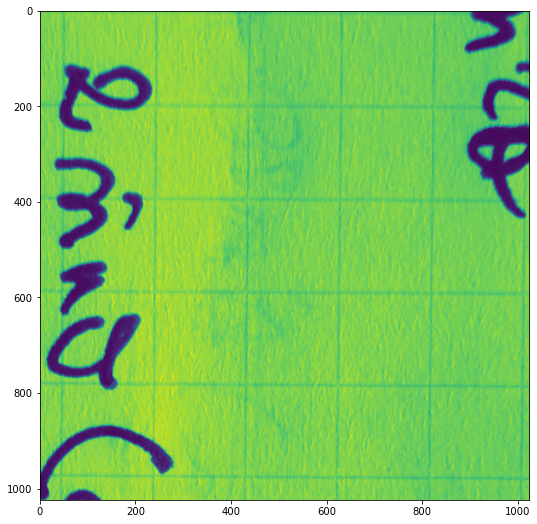

In [3]:
plt.imshow(image)

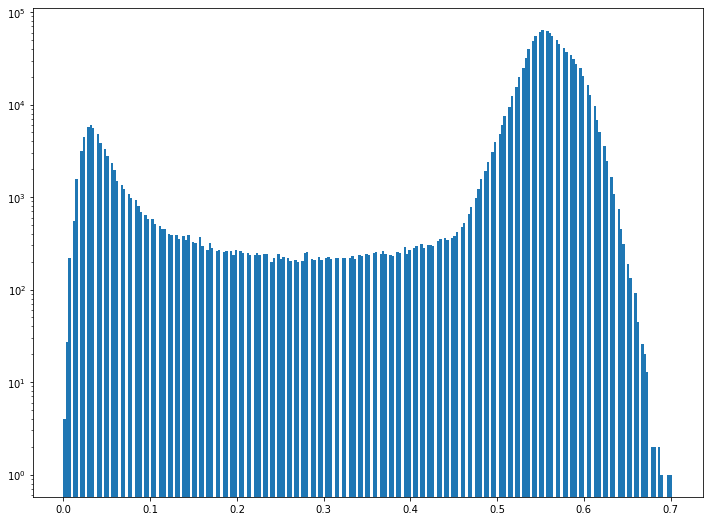

In [4]:
fig, ax = plt.subplots()
h = ax.hist(image.ravel(), bins=256)
ax.set_yscale('log')

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
α : 2.207e+00
β : -2.142e-01
resolution : 9.326e-02
Oblique astigmatism: -1.000e+00
Vertical astigmatism: -8.792e-02
Primary Spherical: -5.271e-03


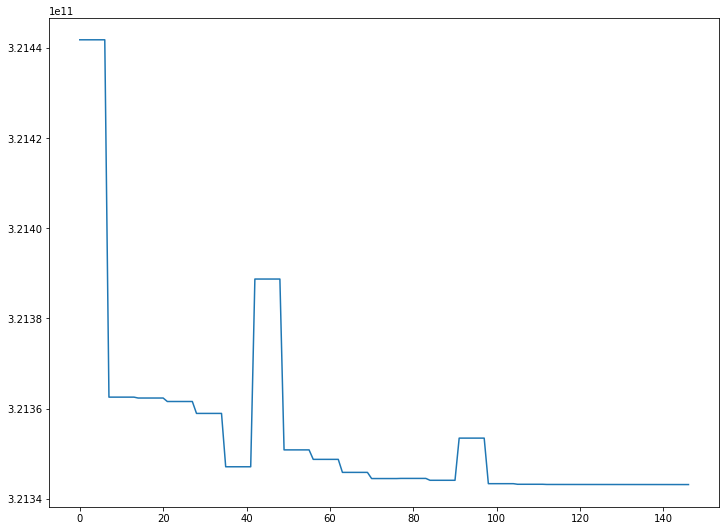

In [13]:
modes = [(2, -2), (2, 2), (4, 0)]
params, costs = deconvolution(image, modes=modes, resolution=2, alpha=1, method="L-BFGS-B")


print(f'α : {params["α"]:.3e}')
print(f'β : {params["β"]:.3e}')
print(f'resolution : {params["resolution"]:.3e}')
pupil = params["resolution"] / np.pi
for mode in modes:
    print(f"{MODE_NAMES[mode]}: {params[mode]: .3e}")

plt.plot(costs)

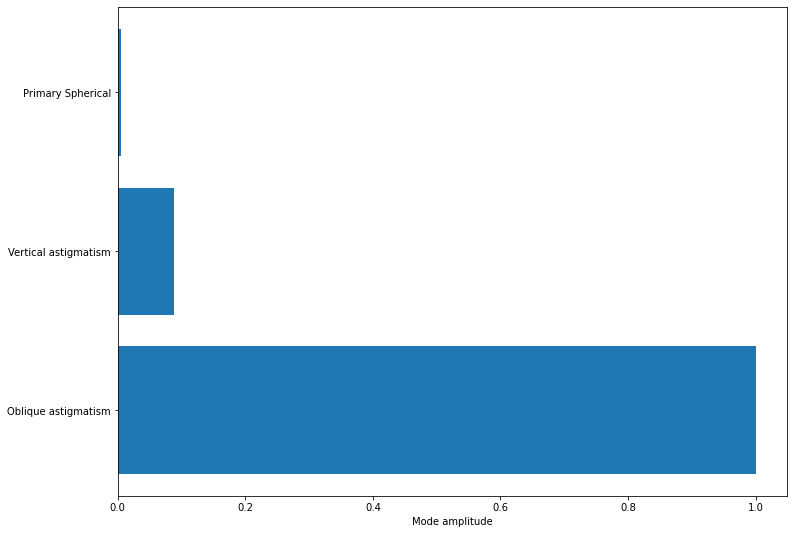

In [14]:
mode_names = [MODE_NAMES[mode] for mode in modes]
amps = [params[mode] for mode in modes]

fig, ax = plt.subplots()
b = ax.barh(np.arange(len(amps)), np.abs(amps))
_ = ax.set_yticks(np.arange(len(amps)))
lbls = ax.set_yticklabels(mode_names)
_ = ax.set_xlabel('Mode amplitude')


In [ ]:
pupil

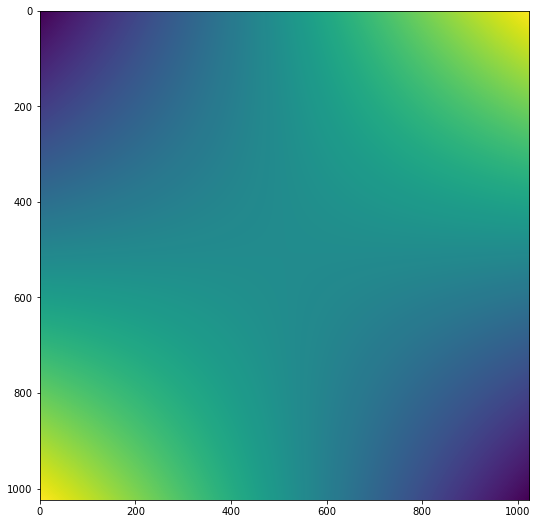

In [15]:


amps = [params[mode] for mode in modes]
nx, ny = image.shape
xx, yy = np.meshgrid(np.linspace(-1, 1, ny), np.linspace(-1, 1, nx))
rho = (xx ** 2 + yy ** 2) ** 0.5
phi = np.arctan2(yy, xx)

tf = zernike_tf(rho, phi, pupil, amps, modes)

fig, ax_z = plt.subplots()
_ = ax_z.imshow(tf)



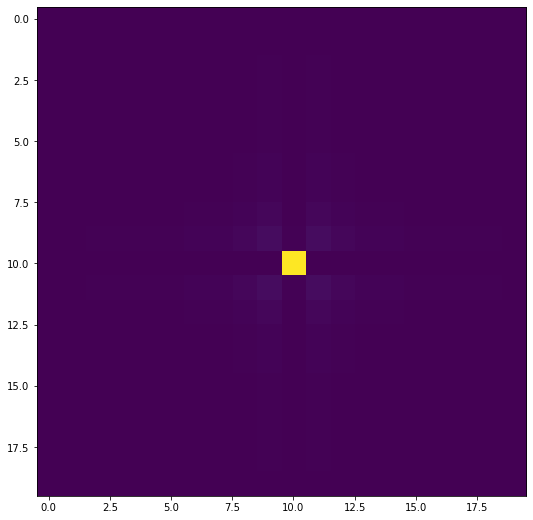

In [16]:
psf = _ifft(tf)
win = 10

plt.imshow(np.abs(psf)[nx//2-win: nx//2+win, ny//2-win: ny//2+win])

In [17]:
tf_astigmatic = zernike_tf(rho, phi, 4, [0.1, 1.2, 0, 0], modes)

image_astigm = np.real(_ifft(_fft(image) * tf_astigmatic))

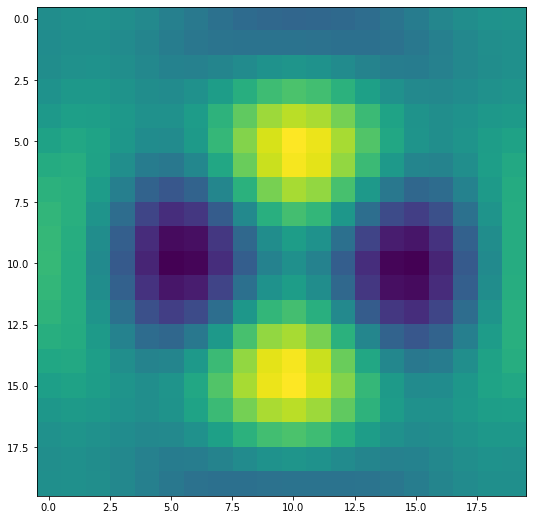

In [18]:
plt.imshow(_fft(tf_astigmatic).real[nx//2-win: nx//2+win, ny//2-win: ny//2+win])

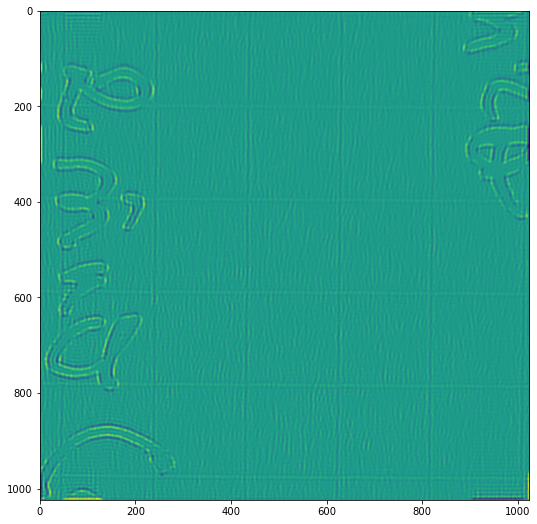

In [19]:
plt.imshow(image_astigm)

In [26]:
modes = [(2, -2), (2, 2), (4, 0)]


params, costs = deconvolution(
    image_astigm,
    modes=modes,
    resolution=4,
    method="L-BFGS-B",
    alpha=1.0,
    options={"ftol": 1e-8, 'gtol': 1e-8}
)


print(f'α : {params["α"]:.3e}')
print(f'β : {params["β"]:.3e}')
print(f'resolution : {params["resolution"]:.3e}')
pupil = params["resolution"] / np.pi
#for mode in modes:
#    print(f"{MODE_NAMES[mode]}: {params[mode]: .3e}")


/home/guillaume/Dev/auto_metro/auto_metro/myopic_deconv.py:32: RuntimeWarning: overflow encountered in power
  return (10 ** alpha) * (r ** (np.abs(beta)))
/home/guillaume/Dev/auto_metro/auto_metro/myopic_deconv.py:32: RuntimeWarning: invalid value encountered in multiply
  return (10 ** alpha) * (r ** (np.abs(beta)))
/home/guillaume/Dev/auto_metro/auto_metro/myopic_deconv.py:59: RuntimeWarning: invalid value encountered in true_divide
  w = prior / (mtf2 + prior)


b'ABNORMAL_TERMINATION_IN_LNSRCH'
α : 7.867e-01
β : 2.262e-01
resolution : 2.809e+00


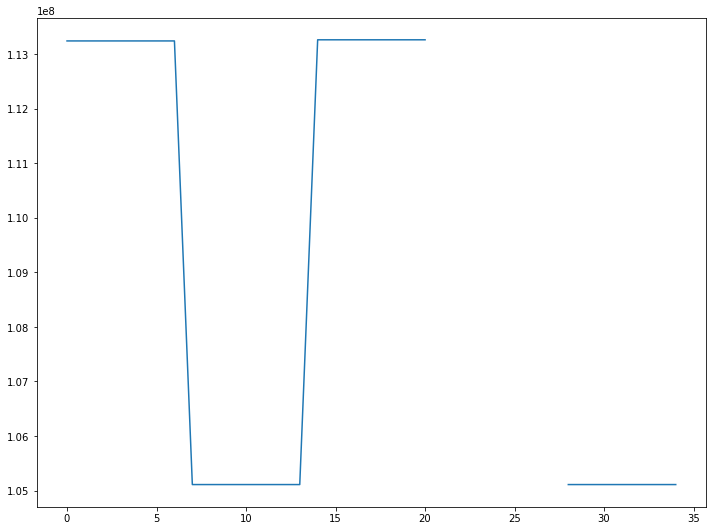

In [27]:
plt.plot(costs)

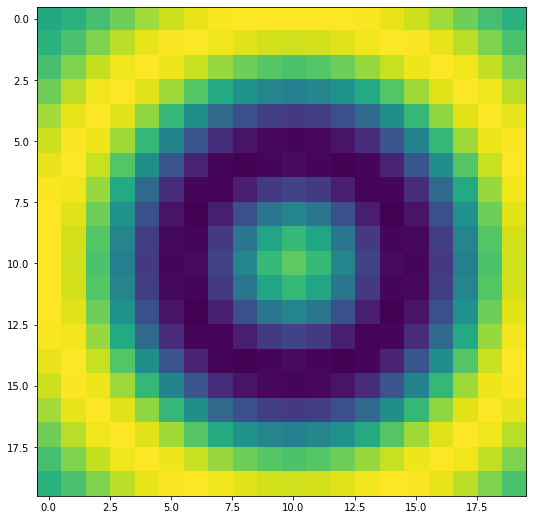

In [25]:
modes = [(2, 0)]
amps = [params[mode] for mode in modes]

tf = zernike_tf(rho, phi, params["resolution"], amps, modes)

psf = _ifft(tf).real
plt.imshow(psf[nx//2-win: nx//2+win, ny//2-win: ny//2+win])

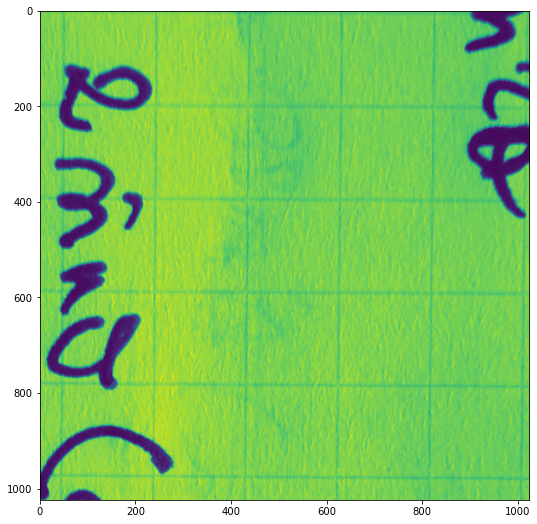

In [17]:
plt.imshow(image)

In [ ]:
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

# your program goes here

javabridge.kill_vm()
